In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
import h5py
import numpy as np
import seaborn as sn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib as mpl

In [3]:
#Plotting style
y_labels = ["red", "green"]
x_labels = ["x1", "x2"]
label_index = [0, 1]

In [4]:
def plot_conf_matrix(confusion, accuracy, labels, ax):
    """
    plot confusion matrix
    """
    
    #Generate the confusion matrix
    cf_matrix = confusion_matrix(confusion["Truth"], confusion["Inferred_color"], normalize="true")
    cf_matrix = 100*np.round(cf_matrix, 4)
    group_percentages = ["{0:0.2%}".format(value/100) for value in cf_matrix.flatten()]
    annot = [f"{item}" for item in group_percentages]
    annot = np.asarray(annot).reshape(len(labels),len(labels))
    sn.heatmap(
            cf_matrix, 
            ax=ax, 
            annot=annot, 
            cmap='rocket', 
            linewidths=1.0, 
            linecolor='black',
            cbar = True, 
            square=True, 
            fmt='', 
            cbar_kws={"format": "%.0f%%", "shrink": 0.8},
            vmin=0,
            vmax=100,
            #annot_kws={"size": 24}
        )

    #ax.set_title('Confusion matrix\n\n', size=24)
    ax.set_xlabel('Predicted labels', size=14)
    ax.set_ylabel('True labels', size=14)

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(labels, size=12, rotation=20)
    ax.yaxis.set_ticklabels(labels, size=12, rotation=70)
    ax.tick_params(which="both", left=False, bottom=False, top=False, right=False)
    ax.set_title(f"Validation accuracy: {round(accuracy, 2)*100} %")
    #print(f"Accuracy: {accuracy}")

    ## Display the visualization of the Confusion Matrix.
    #fig.savefig(f"../results/figures/ResNet18_{N_TEST}_events_CUT_conf_matrix.pdf", format="pdf", bbox_inches='tight')
    return ax

In [5]:
def process_data(file, x_labels, test=False):
    # Read data
    data = h5py.File(file, "r")
    df = pd.DataFrame(columns = x_labels)

    for i in range(len(x_labels)):
        df[x_labels[i]] = np.array(data["data"][:, label_index[i]]).flatten()

    # Get truth label values (annoying because text is not read as text, should fix)
    if (test == False):
        df["Truth_value"] = data["truth"]
        red = df["Truth_value"][len(df)-1]
        df["Truth"] = "green"
        #df["Truth"][df["Truth_value"] == green] = "green"
        df_copy = df.copy()
        mask = df_copy["Truth_value"] == red
        df.loc[mask, "Truth"] = "red"
    
    # Get estimated probabilities
    df["red"] = data["probabilities"][:,0]
    df["green"] = data["probabilities"][:,1]
    df["P(green|x)"] = data["probabilities"][:,1]

    # Get inferred color
    df["Inferred_color"] = df[['red','green']].idxmax(axis=1)

    # Get error bars
    df["quantile25_red"] = data["quantiles"][:, 1, 0]
    df["quantile75_red"] = data["quantiles"][:, 2, 0]
    df["quantile25_green"] = data["quantiles"][:, 1, 1]
    df["quantile75_green"] = data["quantiles"][:, 2, 1]
    
    # Errors are the same
    df["Error"] = df["quantile75_red"] - df["quantile25_red"]
    #df["Error_green"] = df["quantile75_green"] - df["quantile25_green"]

    return df

In [6]:
def plot_data(df, ax):
    ax.set_title("Training data")
    df_red = df[df["color"] == "red"]
    sn.scatterplot(df_red, x="x1", y = "x2", c="red", alpha=0.5, ax=ax)
    
    df_green = df[df["color"] == "green"]
    sn.scatterplot(df_green, x="x1", y = "x2", c="green", alpha=0.5, ax=ax)
    
    ax.set_xlim(-25, 25)
    ax.set_ylim(-25, 25)

    return ax

In [7]:
# Custom plot function
def plot_distributions(df):

    fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (15, 8), layout="constrained")

    df_red = df[df["color"] == "red"]
    sn.scatterplot(df_red, x="x1", y = "x2", c="red", alpha=0.1, ax=ax[0][0])
    sn.histplot(df_red[["x1", "x2"]], palette=["#ffae9d", "#a82b11"], alpha=0.5, ax=ax[0][1], element="step")
    
    df_green = df[df["color"] == "green"]
    sn.scatterplot(df_green, x="x1", y = "x2", c="green", alpha=0.1, ax=ax[1][0])
    sn.histplot(df_green[["x1", "x2"]], palette=["#c3e6c5", "#0b8e14"], alpha=0.5, ax=ax[1][1], element="step")
    
    ax[0][0].set_xlim(min(df["x1"]), max(df["x1"]))
    ax[1][0].set_xlim(min(df["x1"]), max(df["x1"]))
    ax[0][0].set_ylim(min(df["x2"]), max(df["x2"]))
    ax[1][0].set_ylim(min(df["x2"]), max(df["x2"]))
    
    # Plot r1
    sn.histplot(df_red, x="r1", color="red", ax=ax[0][2])
    sn.histplot(df_green, x="r1", color="green", ax=ax[1][2])

    return fig, ax



In [18]:
def plot_results(df, ax, suptitle, grid=False):
    ax.set_title(suptitle)
    sn.set_theme(style="whitegrid")
    #cmap = sn.cubehelix_palette(rot=-.2, as_cmap=True)

    c = ["darkred","red","lightcoral","grey", "palegreen","green","darkgreen"]
    v = [0,.15,.4,.5,0.6,.9,1.]
    l = list(zip(v,c))
    cmap = LinearSegmentedColormap.from_list('rg',l, N=256)
    if grid:
        ax.hist2d(x= df["x1"], y=df["x2"], weights=df["P(green|x)"], 
                bins = 60,
                norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False),
                cmap=cmap)
    else:
        sn.scatterplot(data = df, x="x1", y="x2", ax = ax, hue="P(green|x)", 
                    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False),
                    size="Error", size_norm = (0.1, 0.3), sizes=(10, 200),
                        palette=cmap, legend=False)
    
    ax.set_xlim(-25, 25)
    ax.set_ylim(-25, 25)
    ax.set_xlim(-25, 25)
    ax.set_xlim(-25, 25)

    return ax
    


In [23]:
def plot_uncertainties(df, ax, suptitle, grid=False):
    ax.set_title(suptitle)
    sn.set_theme(style="whitegrid")
    #cmap = sn.cubehelix_palette(rot=-.2, as_cmap=True)

    if grid:
        ax.hist2d(x= df["x1"], y=df["x2"], weights=df["Error"], 
                bins = 60,
                norm = mpl.colors.Normalize(vmin=0.1, vmax=0.3, clip=False))
    else:
        sn.scatterplot(data = df, x="x1", y="x2", ax = ax, hue="Error", 
                    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False),
                    #size="Error", size_norm = (0.1, 0.3), sizes=(10, 200),
                    legend=False)
    
    ax.set_xlim(-25, 25)
    ax.set_ylim(-25, 25)
    ax.set_xlim(-25, 25)
    ax.set_xlim(-25, 25)

    return ax
    

In [19]:
# Setup

#n_data = [2, 4, 8, 16, 32, 64, 128, 256, 300, 500, 512, 900, 1024, 1200, 1500, 1800, 2048, 2100, 2400, 2700, 3000, 4096]
#n_data = [10, 40, 80, 120, 150, 200, 250, 300, 500, 900, 1200, 1500, 1800, 2100, 2400, 2700, 3000, 3300, 3600]
n_data = [900, 1200, 1500, 1800, 2100, 2400, 2700, 3000, 3300, 3600]
#n_data = [2]
folderpath ="inference"

#trainfile = "train_n_5000kr7_kg3_s1_a1_highlow"
#valfile = "val_n_5000_kr7_kg3_s1_a1_highlow"

trainfile = "train_n_5000_kr7_kg3_s1_vary_a1_False"
valfile = "val_n_5000_kr7_kg3_s1_vary_a1_False"

testfile = "x1_x2_grid"

analysis_folders = [f"{trainfile}/nsamples-1200_nchains-20_ndata-{n}" for n in n_data]
valfiles = [f"{folderpath}/{folder}/{valfile}_inferred.h5" for folder in analysis_folders]
testfiles = [f"{folderpath}/{folder}/{testfile}_inferred.h5" for folder in analysis_folders]
train_data = pd.read_csv(f"../data/{trainfile}.csv")

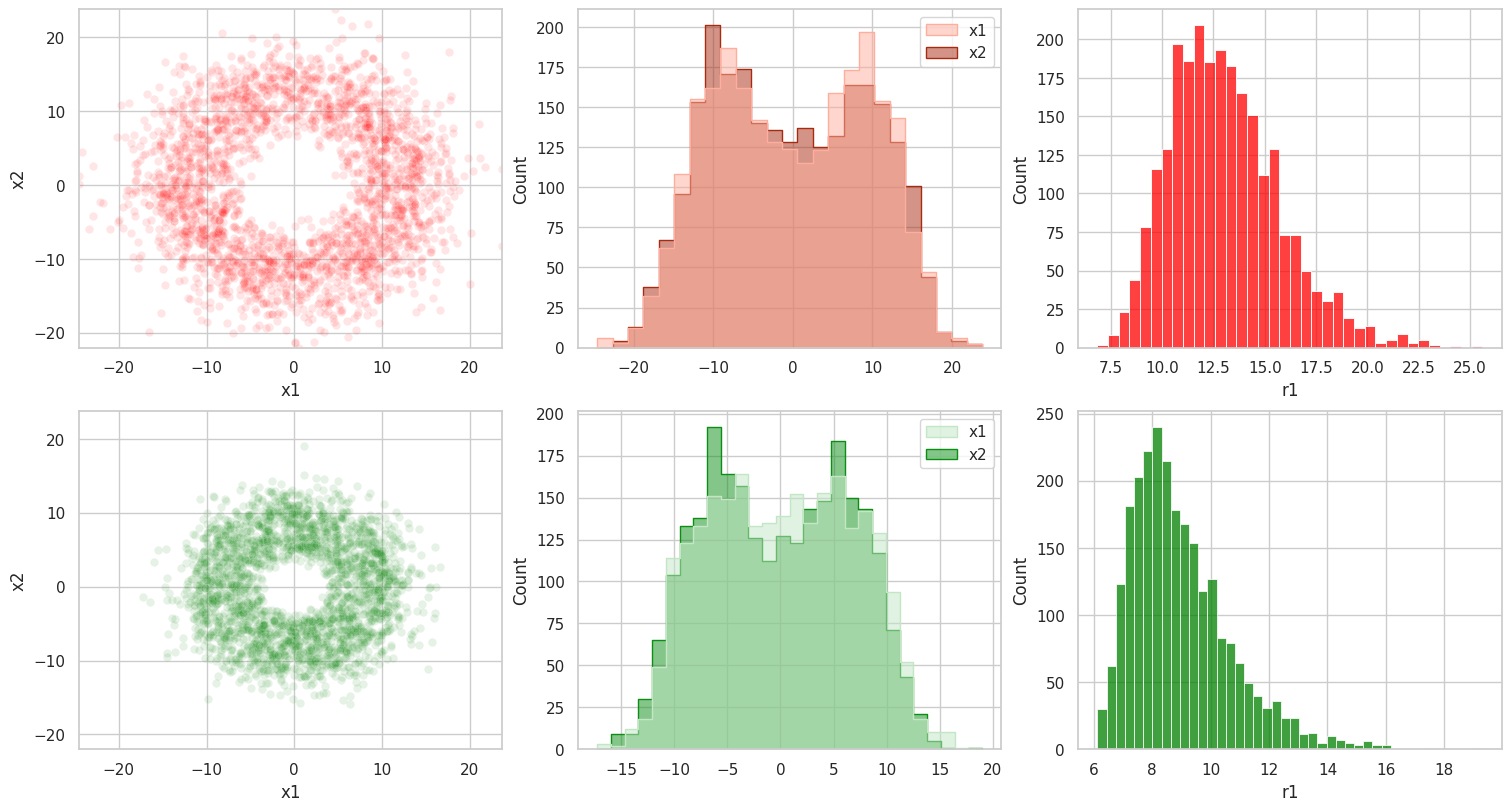

In [20]:
# Plot all training data
fig, ax = plot_distributions(train_data)

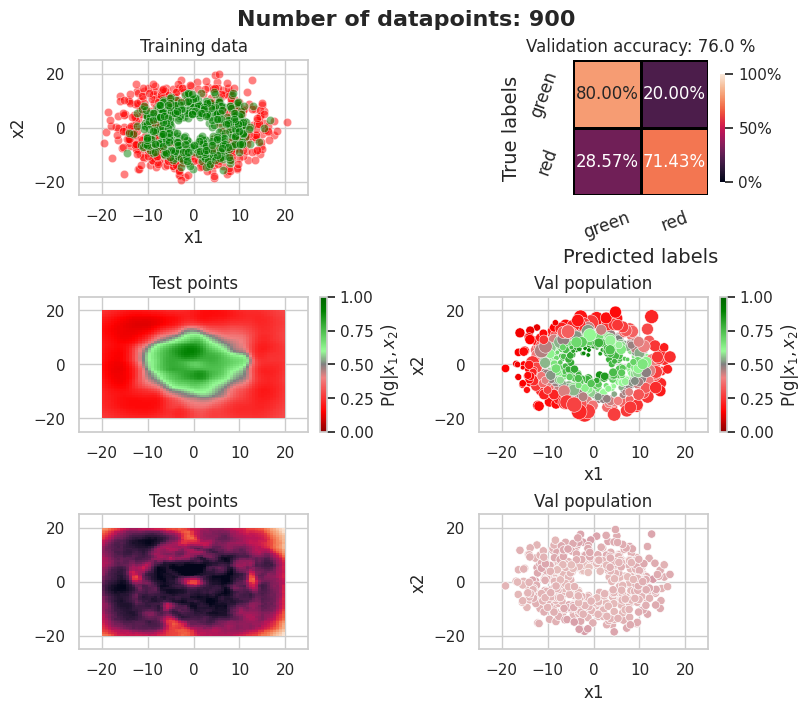

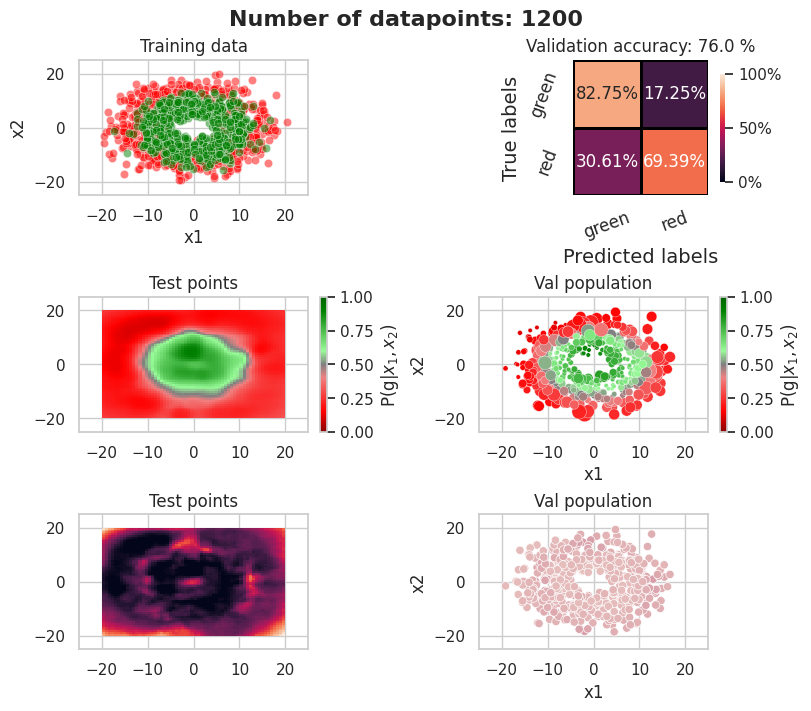

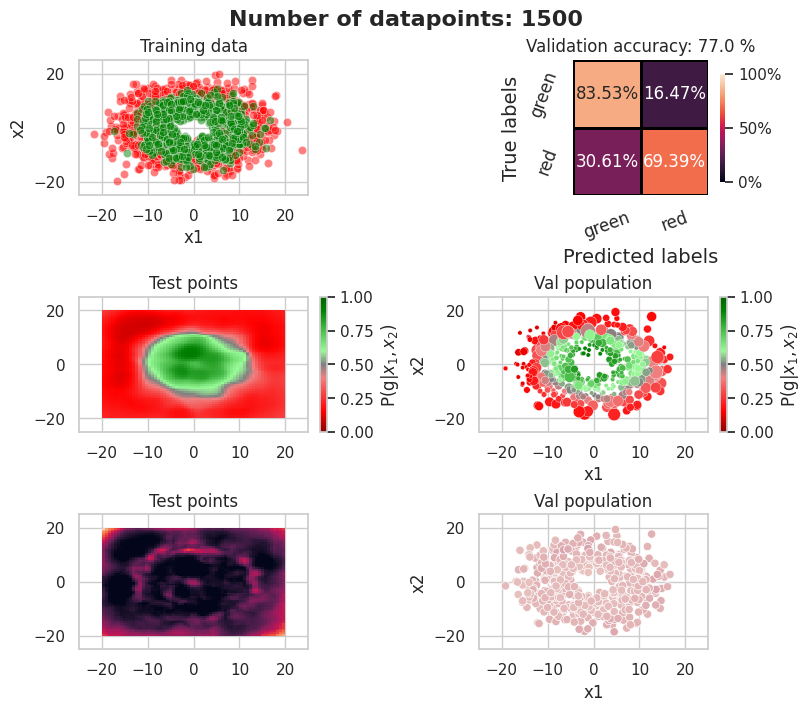

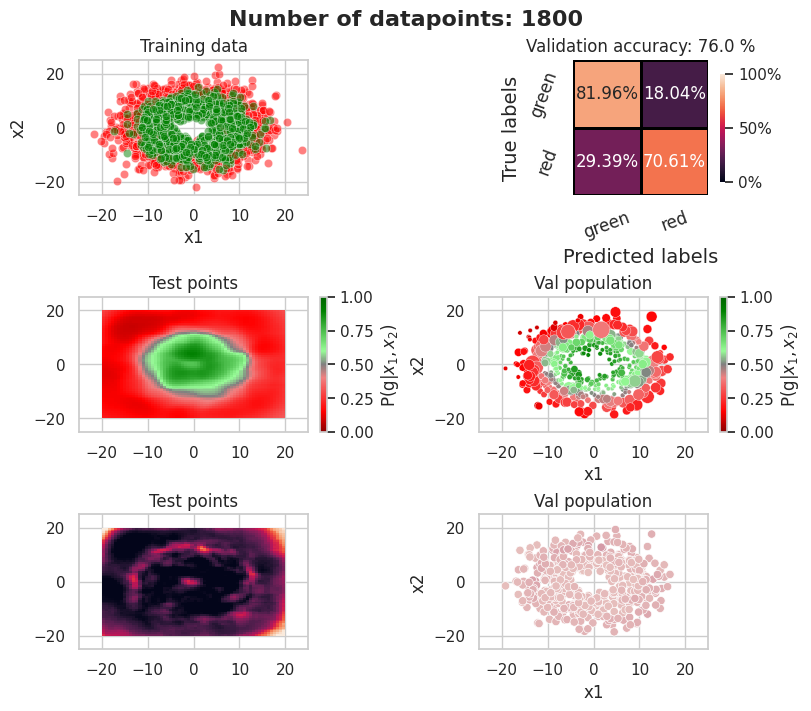

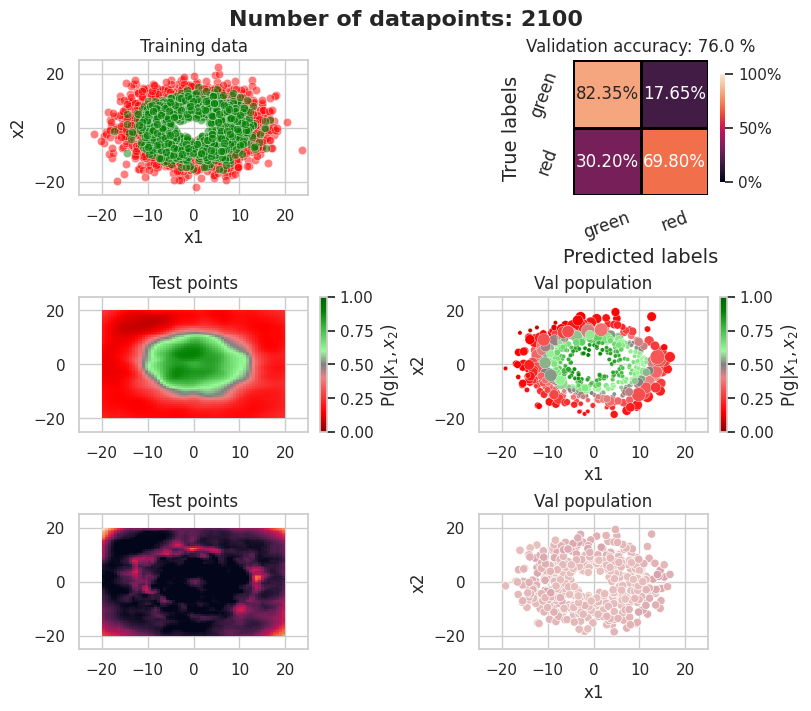

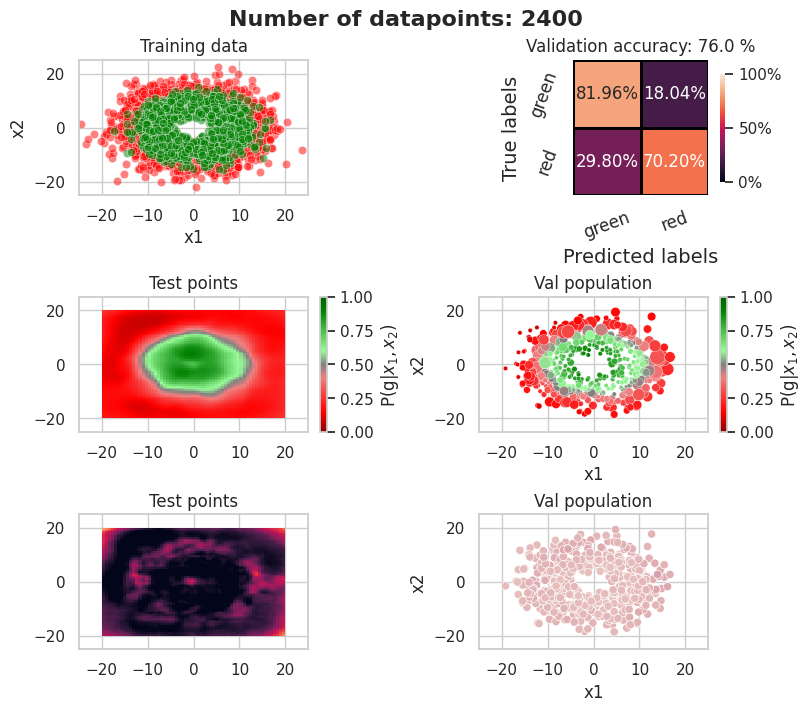

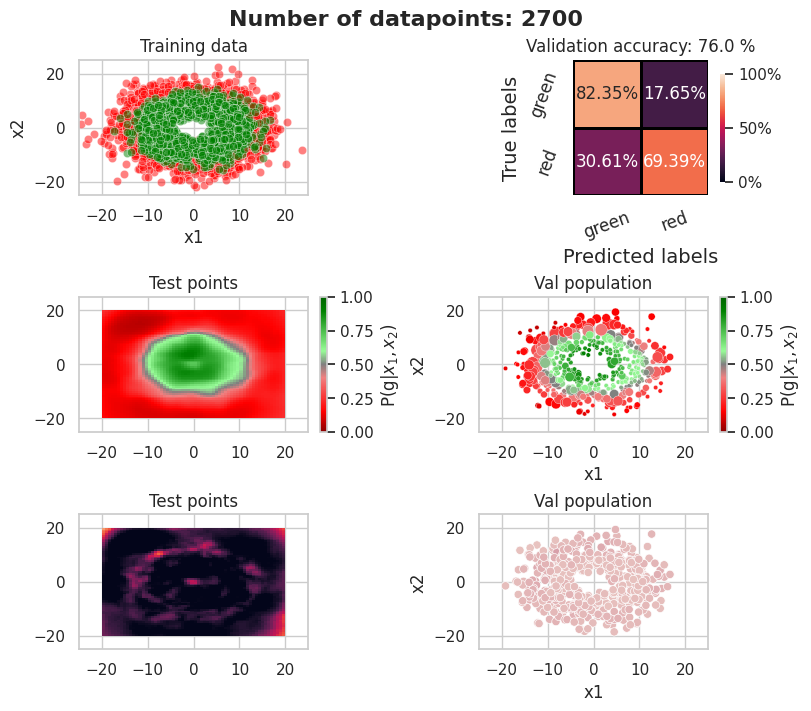

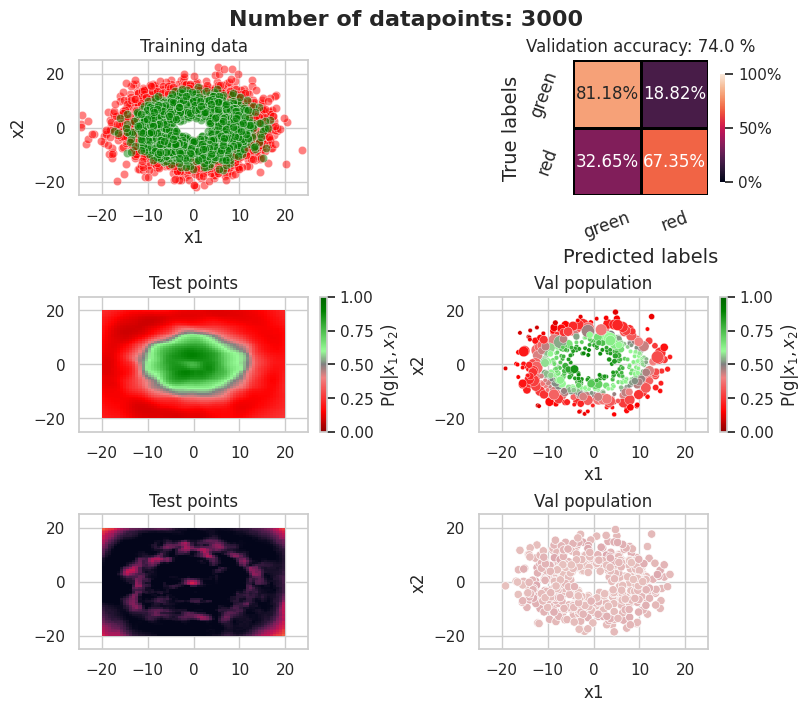

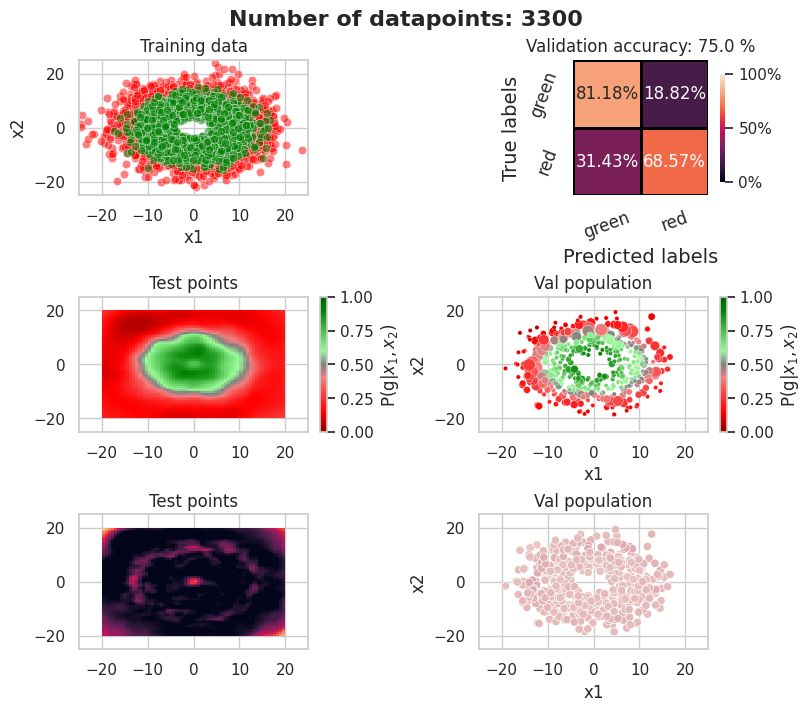

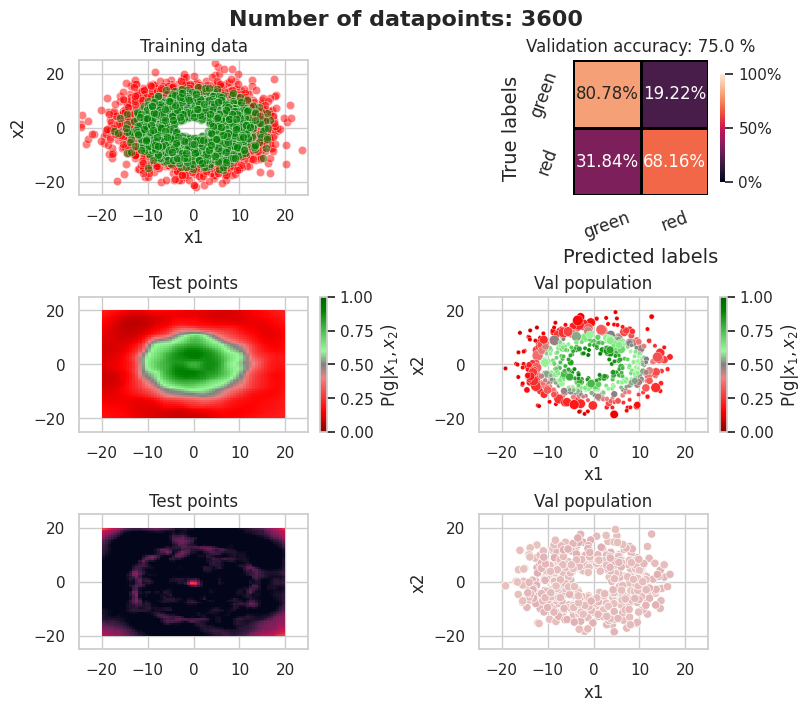

In [25]:

# Plot animation

for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize = (8, 7), layout="constrained")
    df_val = process_data(valfiles[i], x_labels)
    df_test = process_data(testfiles[i], x_labels, test=True)
    accuracy = accuracy_score(df_val["Truth"], df_val["Inferred_color"], normalize=True)
    
    #plot data
    axs[0][0] = plot_data(train_data[0:n_data[i]], axs[0][0])
    axs[0][1] = plot_conf_matrix(df_val, accuracy, ["green", "red"], axs[0][1])
    axs[1][0] = plot_results(df_test, axs[1][0], "Test points", grid=True)
    axs[1][1] = plot_results(df_val, axs[1][1], "Val population")
    axs[2][0] = plot_uncertainties(df_test, axs[2][0], "Test points", grid=True)
    axs[2][1] = plot_uncertainties(df_val, axs[2][1], "Val population")
    
    c = ["darkred","red","lightcoral","grey", "palegreen","green","darkgreen"]
    v = [0,.15,.4,.5,0.6,.9,1.]
    l = list(zip(v,c))
    cmap = LinearSegmentedColormap.from_list('rg',l, N=256)
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'P(g|$x_1, x_2$)', ax=axs[1][0])
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'P(g|$x_1, x_2$)', ax=axs[1][1])
    
    #fig.colorbar(axs[1][0], ax=axs[1][0])
    #axs[1][1] = plot_error(df[df["Truth"] == "red"], axs[1][1])
    #axs[1][2] = plot_error(df[df["Truth"] == "green"], axs[1][2])

    fig.suptitle(f"Number of datapoints: {n_data[i]}", size=16, fontweight="bold")
    #plt.savefig(f"figs/animation/{testfile}_{trainfile}_n_{n_data[i]}")

#plt.show()
    